In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings("ignore")




In [3]:
train_df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test_df = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')

In [4]:
train_df.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


**Basic Statistical Overview**

In [5]:
print("Statistical Summary:")
print(train_df.describe())

Statistical Summary:
                age        balance      duration      campaign         pdays  \
count  39211.000000   39211.000000  39211.000000  39211.000000  39211.000000   
mean      42.120247    5441.781719    439.062789      5.108770     72.256051   
std       12.709352   16365.292065    769.096291      9.890153    160.942593   
min       18.000000   -8019.000000      0.000000      1.000000     -1.000000   
25%       33.000000      98.000000    109.000000      1.000000     -1.000000   
50%       40.000000     549.000000    197.000000      2.000000     -1.000000   
75%       50.000000    2030.000000    380.000000      4.000000     -1.000000   
max       95.000000  102127.000000   4918.000000     63.000000    871.000000   

           previous  
count  39211.000000  
mean      11.826171  
std       44.140259  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max      275.000000  


In [6]:
# Check for missing or null values
print("Missing Values in Training Data:")
print(train_df.isnull().sum())

Missing Values in Training Data:
last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64


In [7]:
# Check unique values for categorical columns
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'target']
for col in categorical_cols:
    print(f"\nUnique values in {col}: {train_df[col].unique()}")

#drop last contact date
train_df = train_df.drop(['last contact date'], axis=1)


Unique values in job: ['blue-collar' 'technician' 'admin.' 'entrepreneur' 'unemployed'
 'management' 'services' 'student' 'self-employed' 'retired' 'housemaid'
 nan]

Unique values in marital: ['married' 'single' 'divorced']

Unique values in education: ['secondary' 'tertiary' 'primary' nan]

Unique values in default: ['no' 'yes']

Unique values in housing: ['yes' 'no']

Unique values in loan: ['no' 'yes']

Unique values in contact: ['cellular' 'telephone' nan]

Unique values in poutcome: ['other' nan 'failure' 'success']

Unique values in target: ['no' 'yes']


**Target Variable Distribution**

Class Counts:
target
no     33384
yes     5827
Name: count, dtype: int64

Class Proportions (%):
target
no     85.139374
yes    14.860626
Name: proportion, dtype: float64


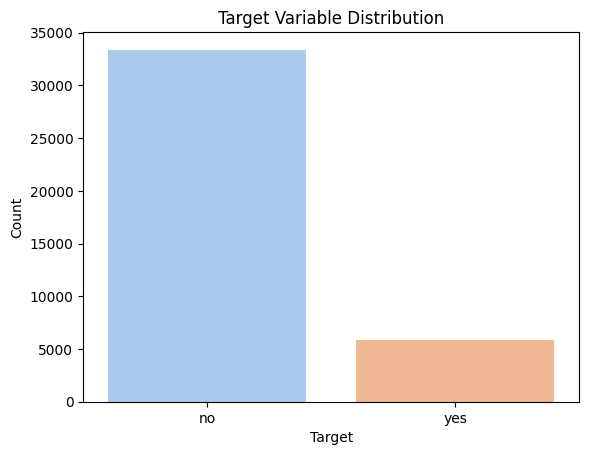

In [8]:
# Calculate class distribution
class_counts = train_df['target'].value_counts()
class_proportions = train_df['target'].value_counts(normalize=True) * 100

# Display class counts and proportions
print("Class Counts:")
print(class_counts)
print("\nClass Proportions (%):")
print(class_proportions)

# Plot the target variable distribution
sns.countplot(x='target', data=train_df, palette='pastel')
plt.title("Target Variable Distribution")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()


**Numeric Variable distribution**

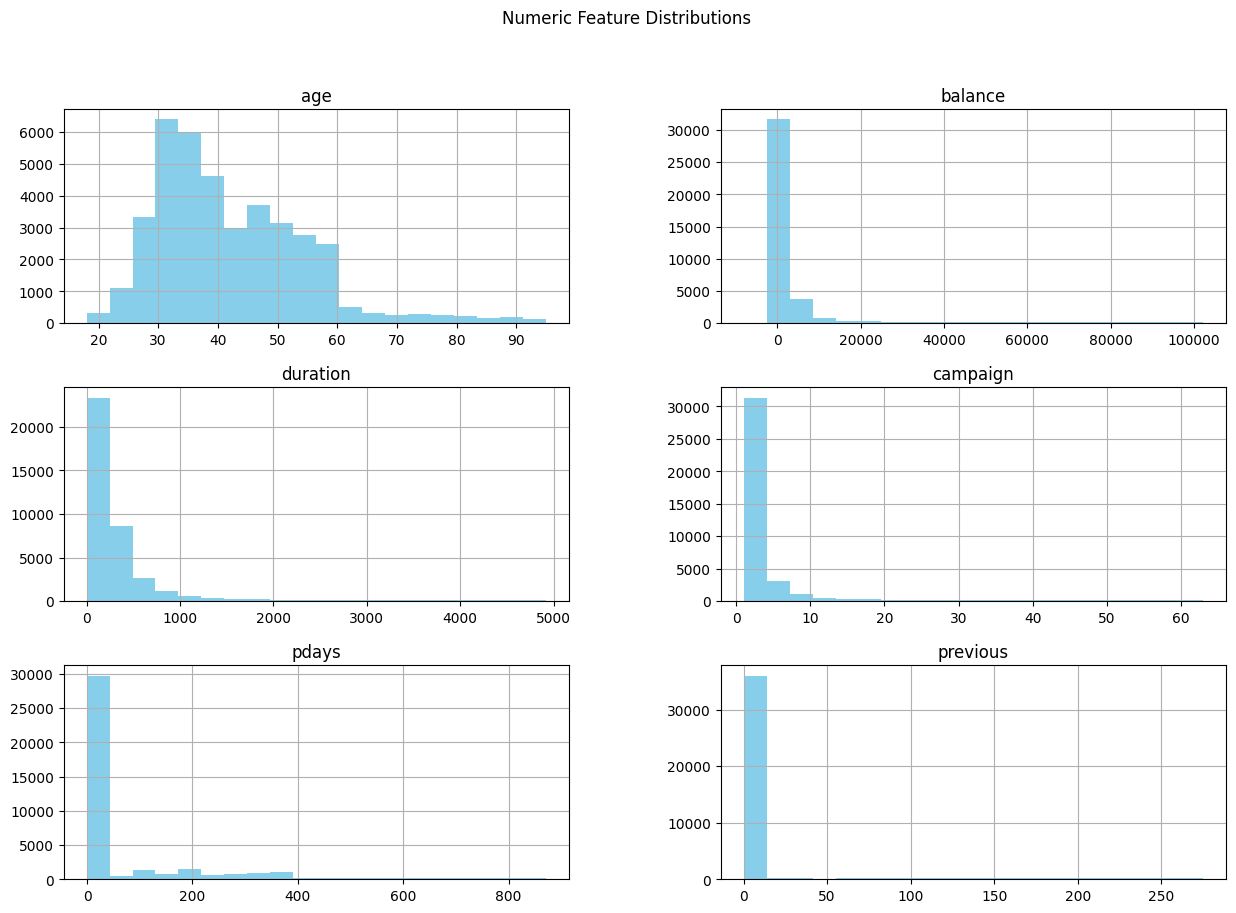

In [9]:
# Histogram for numeric variables
train_df.hist(bins=20, figsize=(15, 10), color='skyblue')
plt.suptitle("Numeric Feature Distributions")
plt.show()

In [10]:
from scipy.stats import kurtosis
# Select numeric columns
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
# Calculate skewness
skewness = train_df[numeric_cols].skew()
# Calculate kurtosis
kurtosis_values = train_df[numeric_cols].apply(kurtosis)
# Create a DataFrame to display the results
skew_kurt_df = pd.DataFrame({
    "Feature": numeric_cols,
    "Skewness": skewness.values,
    "Kurtosis": kurtosis_values.values
}).reset_index(drop=True)
# Display the results
print("Skewness and Kurtosis of Numeric Features:")
print(skew_kurt_df)

Skewness and Kurtosis of Numeric Features:
    Feature  Skewness   Kurtosis
0       age  1.124278   1.760536
1   balance  4.063587  16.307563
2  duration  3.700585  14.233022
3  campaign  3.839593  15.025544
4     pdays  2.611773   6.913595
5  previous  4.206573  17.279437


In [11]:
# Convert column to numeric format
train_df['default'].replace({'yes' : 1, 'no' : 0}, inplace = True)
train_df['housing'].replace({'yes' : 1, 'no' : 0}, inplace = True)
train_df['loan'].replace({'yes' : 1, 'no' : 0}, inplace = True)
train_df['target'].replace({'yes' : 1, 'no' : 0}, inplace = True)


In [12]:
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,26,blue-collar,married,secondary,0,647,1,0,cellular,357,2,331,1,other,0
1,52,technician,married,secondary,0,553,1,0,telephone,160,1,-1,0,NaN,0
2,44,blue-collar,married,secondary,0,1397,0,0,cellular,326,1,-1,0,NaN,0
3,33,admin.,married,secondary,0,394,1,0,telephone,104,3,-1,0,NaN,0
4,31,entrepreneur,single,tertiary,0,137,0,0,cellular,445,2,-1,0,NaN,0


**Correlation Heatmap**

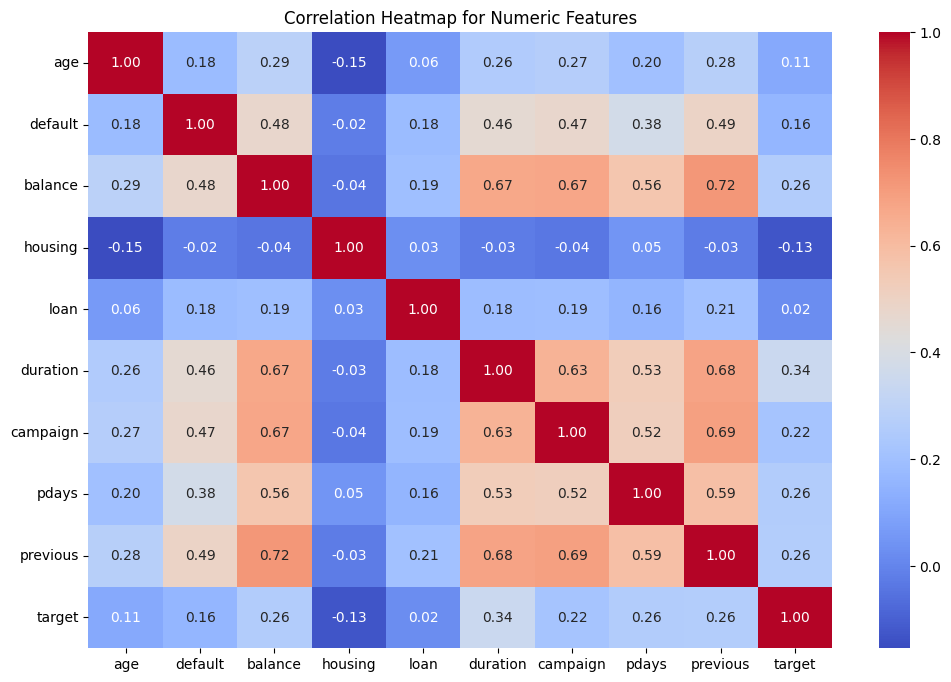

In [13]:
# Select only numeric columns for correlation
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns

# Compute correlation matrix
corr = train_df[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap for Numeric Features")
plt.show()


Categorical Features vs Target

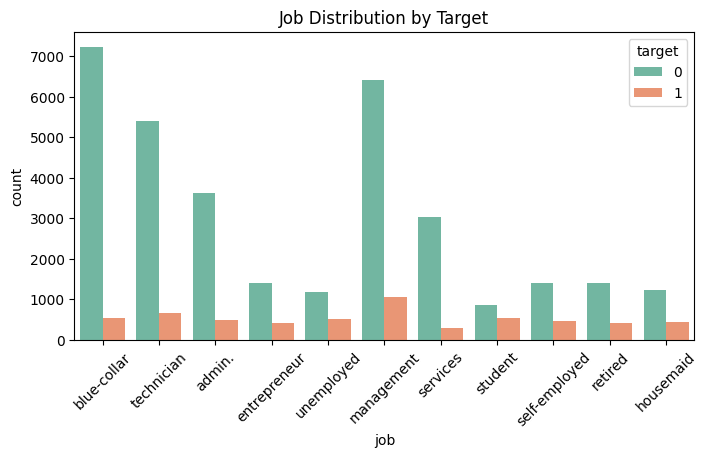

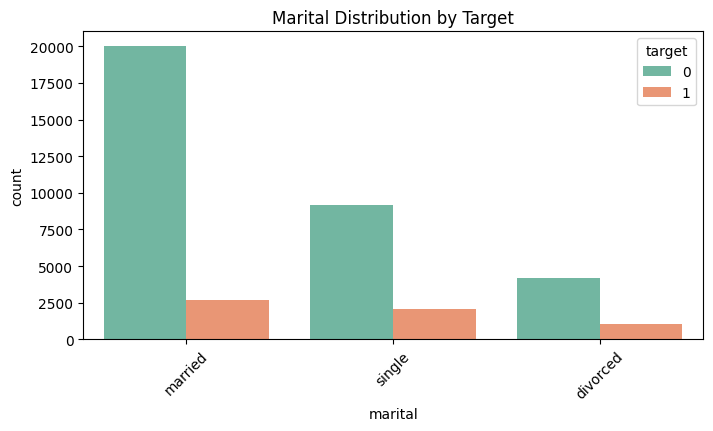

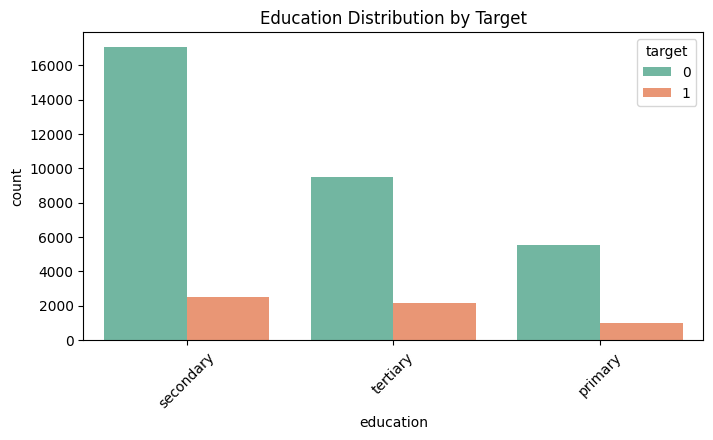

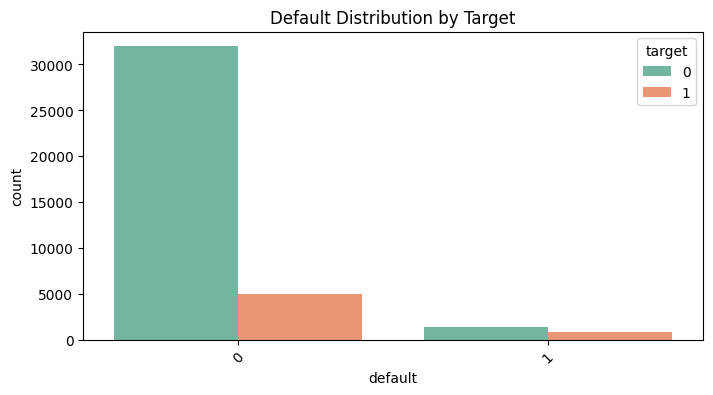

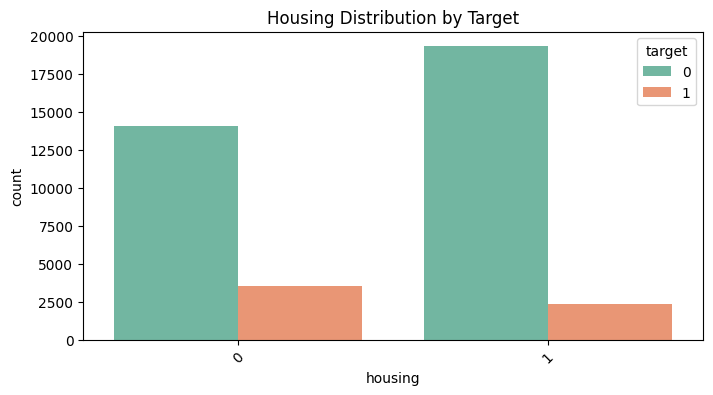

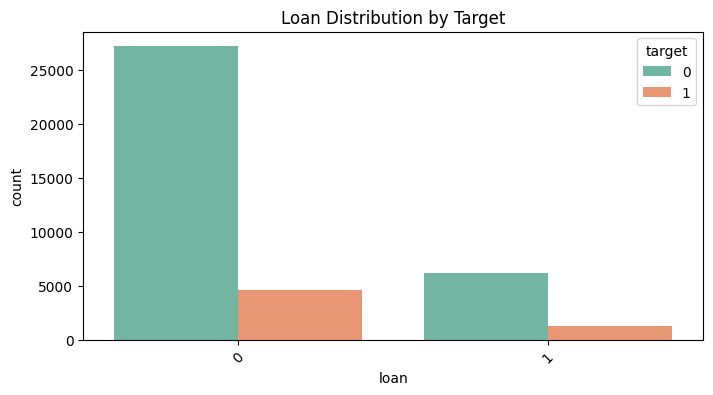

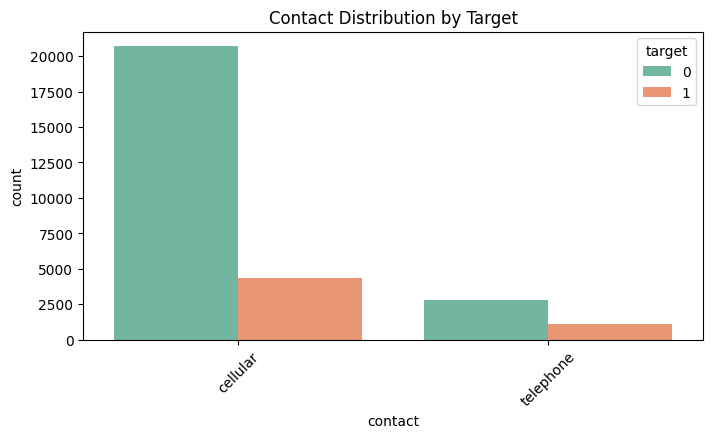

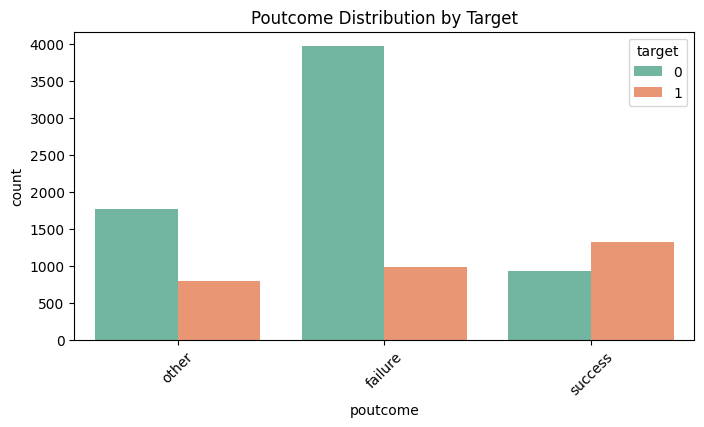

In [14]:
# Categorical features vs target
for col in categorical_cols[:-1]:  # Exclude the target column itself
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='target', data=train_df, palette='Set2')
    plt.title(f"{col.capitalize()} Distribution by Target")
    plt.xticks(rotation=45)
    plt.show()


In [15]:
train_df[['job']]=SimpleImputer(strategy='most_frequent').fit_transform(train_df[['job']])
train_df[['education']]=SimpleImputer(strategy='most_frequent').fit_transform(train_df[['education']])
train_df[['contact']]=SimpleImputer(strategy='most_frequent').fit_transform(train_df[['contact']])

In [16]:
print(train_df.isnull().sum())

age              0
job              0
marital          0
education        0
default          0
balance          0
housing          0
loan             0
contact          0
duration         0
campaign         0
pdays            0
previous         0
poutcome     29451
target           0
dtype: int64


In [17]:
train_df['poutcome']=train_df['poutcome'].fillna('unknown')

In [18]:
print(train_df.isnull().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
target       0
dtype: int64


In [19]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Identify categorical columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

# Apply One-Hot Encoding
encoder = OneHotEncoder(sparse=False, drop='first')  # Drop one category to avoid multicollinearity
encoded_data = encoder.fit_transform(train_df[categorical_columns])

# Convert encoded data back to DataFrame
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_columns))

# Combine with the original DataFrame (excluding the original categorical columns)
numeric_columns = train_df.drop(columns=categorical_columns + ['target']).reset_index(drop=True)
X = pd.concat([numeric_columns, encoded_df], axis=1)
y = train_df['target']


In [20]:
from sklearn.preprocessing import LabelEncoder

# Apply Label Encoding
label_encoder = LabelEncoder()
for column in categorical_columns:
    train_df[column] = label_encoder.fit_transform(train_df[column])

X = train_df.drop(columns=['target'])
y = train_df['target']


In [21]:
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['target'])
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Now Baseline Model

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8489098559224787
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      6645
           1       0.52      0.14      0.22      1198

    accuracy                           0.85      7843
   macro avg       0.69      0.56      0.57      7843
weighted avg       0.81      0.85      0.81      7843



In [23]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)


In [24]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced')

In [25]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.7860512558969782
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87      6645
           1       0.38      0.62      0.47      1198

    accuracy                           0.79      7843
   macro avg       0.65      0.72      0.67      7843
weighted avg       0.84      0.79      0.81      7843

Confusion Matrix:
 [[5421 1224]
 [ 454  744]]


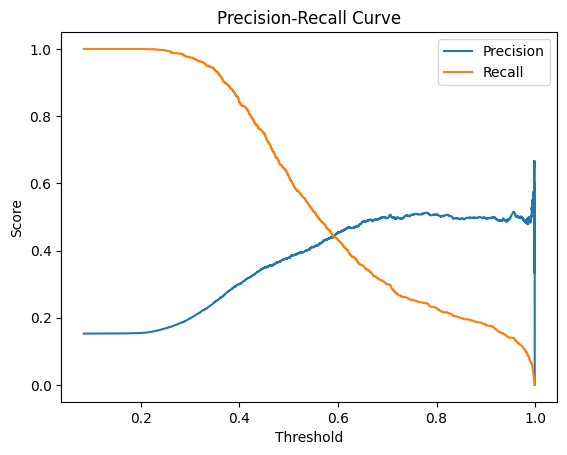

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.48      0.64      6645
           1       0.24      0.94      0.39      1198

    accuracy                           0.55      7843
   macro avg       0.61      0.71      0.51      7843
weighted avg       0.87      0.55      0.60      7843

Confusion Matrix:
[[3160 3485]
 [  68 1130]]


In [26]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get predicted probabilities for class 1
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot Precision-Recall Curve
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall Curve")
plt.show()

# Find an optimal threshold (you can choose the threshold that balances precision and recall best)
optimal_threshold = thresholds[np.argmax(precision + recall)]  # Example of threshold selection

# Predict using the optimal threshold
y_pred_optimal = (y_probs >= optimal_threshold).astype(int)

# Evaluate the model with the new threshold
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, y_pred_optimal))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimal))


In [27]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train a new model on the balanced data
model_smote = LogisticRegression(class_weight='balanced')
model_smote.fit(X_train_balanced, y_train_balanced)

# Evaluate the model on the test data
y_pred_smote = model_smote.predict(X_test)

# Print the classification report and confusion matrix for the model trained with SMOTE
print("Classification Report for SMOTE model:")
print(classification_report(y_test, y_pred_smote))

print("Confusion Matrix for SMOTE model:")
print(confusion_matrix(y_test, y_pred_smote))


Classification Report for SMOTE model:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      6645
           1       0.39      0.60      0.47      1198

    accuracy                           0.79      7843
   macro avg       0.65      0.71      0.67      7843
weighted avg       0.84      0.79      0.81      7843

Confusion Matrix for SMOTE model:
[[5517 1128]
 [ 482  716]]


In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Assuming X_train and y_train are your training data
# If you have feature selection or resampling applied, replace X_train and y_train with the appropriate variables
param_grid = {
    'C': [0.001, 0.01, 0.1, 1],         # Regularization strength
    'solver': ['liblinear'],             # Solver to use
    'penalty': ['l1', 'l2'],             # Penalty (Regularization method)
    'max_iter': [100, 200, 500]          # Maximum number of iterations
}

# Step 2: Initialize GridSearchCV
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42),
                           param_grid, 
                           cv=5,                            # 5-fold cross-validation
                           scoring='f1_macro',              # Optimize for f1_macro score
                           n_jobs=-1)                        # Use all CPU cores

# Step 3: Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)  # Replace X_train and y_train with your actual training set

# Step 4: Get the best parameters found by GridSearchCV
print("Best Parameters: ", grid_search.best_params_)

# Step 5: Get the best estimator (model) found
best_model = grid_search.best_estimator_

# Step 6: Evaluate the best model
y_pred = best_model.predict(X_test)

# Step 7: Performance Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Best Parameters:  {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.8134642356241234
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.84      0.88      6645
           1       0.43      0.65      0.52      1198

    accuracy                           0.81      7843
   macro avg       0.68      0.75      0.70      7843
weighted avg       0.85      0.81      0.83      7843

Confusion Matrix:
[[5601 1044]
 [ 419  779]]


In [29]:
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensions
pca = PCA(n_components=10)  # Set the number of components based on explained variance or domain knowledge
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")


Explained Variance Ratio: [9.98689204e-01 1.24420072e-03 6.29582818e-05 2.87827273e-06
 5.52444621e-07 1.59951015e-07 3.91662785e-08 1.98703782e-09
 1.62919722e-09 1.31711998e-09]


In [32]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select top k features
k_best = SelectKBest(score_func=f_classif, k=10)  # Adjust k based on your dataset
X_train = k_best.fit_transform(X_train, y_train)
X_test = k_best.transform(X_test)

# Get selected feature scores
print("Feature Scores:", k_best.scores_)


Feature Scores: [ 425.67182399  191.07096656    4.54165677   54.61502774  787.43478946
 2251.94468767  529.73482873   20.22678811  510.73749781 4217.58263838
 1589.11465371 2309.2990221  2377.40118733  972.57536674]


In [33]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_selected, y_train)

# Evaluate
y_pred_nb = nb_model.predict(X_test)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Naive Bayes Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.8449572867525181
Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91      6645
           1       0.49      0.27      0.35      1198

    accuracy                           0.84      7843
   macro avg       0.68      0.61      0.63      7843
weighted avg       0.82      0.84      0.83      7843

Naive Bayes Confusion Matrix:
 [[6302  343]
 [ 873  325]]


In [35]:
from sklearn.neighbors import KNeighborsClassifier

# Train Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)  # Adjust neighbors via tuning
knn_model.fit(X_train, y_train)

# Evaluate
y_pred_knn = knn_model.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))


KNN Accuracy: 0.8434272599770496
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.91      6645
           1       0.48      0.32      0.39      1198

    accuracy                           0.84      7843
   macro avg       0.68      0.63      0.65      7843
weighted avg       0.82      0.84      0.83      7843

KNN Confusion Matrix:
 [[6226  419]
 [ 809  389]]


In [37]:
from sklearn.svm import SVC

# Train SVM
svm_model = SVC(kernel='rbf', C=1, random_state=42)  # Adjust kernel and C via tuning
svm_model.fit(X_train, y_train)

# Evaluate
y_pred_svm = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("SVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


SVM Accuracy: 0.846997322453143
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92      6645
           1       0.49      0.08      0.14      1198

    accuracy                           0.85      7843
   macro avg       0.68      0.53      0.53      7843
weighted avg       0.80      0.85      0.80      7843

SVM Confusion Matrix:
 [[6544  101]
 [1099   99]]


In [46]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Assuming X_train, y_train, X_test, y_test are already defined
# If not, split the data like this:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2.1 Create and train the XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=len(y_train) / sum(y_train),  # Adjusting for class imbalance
    use_label_encoder=False,
    random_state=42
)


# Train the model
xgb_model.fit(X_train, y_train)

# 2.2 Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# 2.3 Evaluate the model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


XGBoost Accuracy: 0.8091291597602958
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.81      0.88      6645
           1       0.43      0.79      0.56      1198

    accuracy                           0.81      7843
   macro avg       0.69      0.80      0.72      7843
weighted avg       0.87      0.81      0.83      7843

XGBoost Confusion Matrix:
 [[5403 1242]
 [ 255  943]]

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=10, n_estimators=200, subsample=1.0; total time=   1.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=1.0; total time=   1.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=0.8; total time=   2.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=10, n_estimators=200, subsample=1.0; total time=   1.7s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subs

In [45]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available processors
    verbose=2
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict with the best model
y_pred_best_xgb = best_model.predict(X_test)

# Evaluate the best model
print("Best XGBoost Model Accuracy:", accuracy_score(y_test, y_pred_best_xgb))
print("Best XGBoost Classification Report:\n", classification_report(y_test, y_pred_best_xgb))
print("Best XGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_xgb))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=6, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END col

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the parameter grid
param_grid = {
    'n_estimators': [300],
    'max_depth': [5, 7, 9, 11],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.1, 0.3, 0.4],
    'scale_pos_weight': [1, 2, 3]
}

# Initialize the XGBoost model
model = XGBClassifier()

# Initialize GridSearchCV with cross-validation (using f1_macro as scoring)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, 
                           scoring='f1_macro', n_jobs=-1, verbose=1)

# Fit the model with the training data
grid_search.fit(X_train_selected, y_train)

# Get the best parameters from GridSearchCV
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Retrieve the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Print results
print("XGBoost with Hyperparameter Tuning Accuracy:", accuracy_score(y_test, y_pred))
print("XGBoost with Hyperparameter Tuning Classification Report:\n", classification_report(y_test, y_pred))
print("XGBoost with Hyperparameter Tuning Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
